In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

In [3]:
uselog = pd.read_csv("../input/use_log.csv")
customer = pd.read_csv("../input/customer_join.csv")

#print(uselog.isnull().sum())
#print(customer.isnull().sum())

In [4]:
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [5]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [6]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [7]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler()
customer_clustering_std = std_scale.fit_transform(customer_clustering)

In [8]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_std)

In [9]:
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [10]:
customer_clustering.groupby("cluster").count()

,mean,median,max,min,membership_period
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [11]:
customer_clustering.groupby("cluster").mean()

,mean,median,max,min,membership_period
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


In [12]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(customer_clustering_std)
X_2D_pca = pca.fit_transform(customer_clustering_std)

X_2D_pca_df = pd.DataFrame(X_2D_pca)
X_2D_pca_df["cluster"] = customer_clustering["cluster"]
X_2D_pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,3
1,-0.707922,-1.799857,3
2,-1.061499,-1.659826,3
3,-1.160764,-1.810139,3
4,-2.017132,-1.670101,3


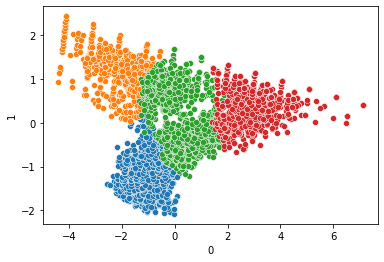

In [13]:
import seaborn as sns

for i in customer_clustering["cluster"].unique():
    tmp = X_2D_pca_df[X_2D_pca_df["cluster"]==i]
    sns.scatterplot(tmp[0], tmp[1])

In [14]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(
    ["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [15]:
customer_clustering.groupby(
    ["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


In [16]:
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [17]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby (["年月", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [18]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()

for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":f"count_{j-1}"}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [19]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [20]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [21]:
from dateutil.relativedelta import relativedelta

predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
predict_data["period"] = None

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [22]:
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
49,201810,AS185951,1,5.0,3.0,3.0,7.0,3.0,10.0,2018-04-09,2018-10-01,5
55,201810,AS197200,12,6.0,8.0,9.0,6.0,8.0,8.0,2018-04-15,2018-10-01,5
56,201810,AS200286,3,6.0,3.0,6.0,6.0,7.0,10.0,2018-04-06,2018-10-01,5
72,201810,AS251169,2,4.0,6.0,5.0,8.0,10.0,7.0,2018-04-03,2018-10-01,5
96,201810,AS345469,1,3.0,5.0,6.0,5.0,4.0,7.0,2018-04-12,2018-10-01,5


In [23]:
type(predict_data)

pandas.core.frame.DataFrame

In [24]:
from sklearn import model_selection

predict_data["kfold"] = -1
predict_data = predict_data.sample(frac=1).reset_index(drop=True)
kf = model_selection.KFold(n_splits=3)

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=predict_data)):
    predict_data.loc[val_idx, "kfold"] = fold

predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period,kfold
0,201903,GD862688,6,5.0,11.0,5.0,8.0,7.0,9.0,2018-05-08,2019-03-01,9,0
1,201812,HD736119,7,7.0,4.0,5.0,7.0,9.0,9.0,2018-05-10,2018-12-01,6,0
2,201903,HI368031,4,6.0,7.0,8.0,10.0,9.0,8.0,2018-04-03,2019-03-01,10,0
3,201901,PL959979,9,9.0,6.0,8.0,11.0,9.0,9.0,2018-05-08,2019-01-01,7,0
4,201812,PL432893,6,8.0,6.0,7.0,8.0,7.0,7.0,2018-05-07,2018-12-01,6,0


In [25]:
from sklearn import linear_model
from sklearn import metrics
import joblib
import os

def run(fold):
    df = predict_data
    
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    xtrain = df_train[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
    ytrain = df_train["count_pred"]
    
    xvalid = df_valid[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
    yvalid = df_valid["count_pred"]
    
    lr = linear_model.LinearRegression()
    lr.fit(xtrain, ytrain)
    coef = pd.DataFrame({"feature_names": xtrain.columns, "coefficient": lr.coef_})
    
    
    print(f"Fold={fold} Accuracy: Train={lr.score(xtrain, ytrain):.3f}, Valid={lr.score(xvalid, yvalid):.3f}")
    print(f"{coef}")
    
    joblib.dump(
        lr, 
        os.path.join("../model/", f"df_{fold}.bin")
    )
    

In [26]:
for j in range(3):
    run(j)

Fold=0 Accuracy: Train=0.618, Valid=0.585
  feature_names  coefficient
0       count_0     0.344785
1       count_1     0.170646
2       count_2     0.173606
3       count_3     0.209621
4       count_4     0.070729
5       count_5     0.069222
6        period     0.106085
Fold=1 Accuracy: Train=0.624, Valid=0.572
  feature_names  coefficient
0       count_0     0.339510
1       count_1     0.205915
2       count_2     0.157773
3       count_3     0.179822
4       count_4     0.081477
5       count_5     0.092336
6        period     0.044269
Fold=2 Accuracy: Train=0.584, Valid=0.649
  feature_names  coefficient
0       count_0     0.322840
1       count_1     0.193421
2       count_2     0.178123
3       count_3     0.161400
4       count_4     0.085064
5       count_5     0.036492
6        period     0.062583


In [27]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]
x_pred

[[3, 4, 4, 6, 8, 7, 8], [2, 2, 3, 3, 4, 6, 8]]

In [28]:
for i in range(3):
    model = joblib.load(f"../model/df_{i}.bin")
    print(model.predict(x_pred))

[3.86199671 2.02131323]
[3.75388405 1.88706023]
[3.81582696 2.06707578]


In [29]:
uselog_months.to_csv("../input/use_log_months.csv", index=False)